https://heartbeat.fritz.ai/introduction-to-generative-adversarial-networks-gans-35ef44f21193

In [33]:
import numpy as np
import keras
import matplotlib.pyplot as plt

from tqdm import tqdm


from keras import initializers
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.layers import Input
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential

In [34]:
# Setup seed to produce smae results across runs with same size
np.random.seed(1000)
random_dim = 100

In [35]:
def load_mnist_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # Normalise input to range (-1,1)
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [36]:
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Generator network
gen = Sequential()
gen.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.2)))
gen.add(LeakyReLU(0.2))
gen.add(Dense(512))
gen.add(LeakyReLU(0.2))
gen.add(Dense(1024))
gen.add(LeakyReLU(0.2))
gen.add(Dense(784, activation='tanh'))
gen.compile(loss='binary_crossentropy', optimizer=optimizer)

In [37]:
# Discriminator Network
dis = Sequential()
dis.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.2)))
dis.add(LeakyReLU(0.2))
dis.add(Dropout(0.3))
dis.add(Dense(512))
dis.add(LeakyReLU(0.2))
dis.add(Dropout(0.3))
dis.add(Dense(256))
dis.add(LeakyReLU(0.2))
dis.add(Dropout(0.3))
dis.add(Dense(1, activation='sigmoid'))
dis.compile(loss='binary_crossentropy', optimizer=optimizer)

In [38]:
dis.trainable = False
ganInput = Input(shape=(random_dim,))

In [39]:
x = gen(ganInput)
ganOutput = dis(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [40]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = gen.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('../gen_output/image_generated_%d.png' % epoch)

In [41]:
def train(epochs=1, batch_size=128):
    x_train, y_train, x_test, y_test = load_mnist_data()
    batch_count = x_train.shape[0] / batch_size

    for e in range(1, epochs+1):
        print('-'*10, 'Epoch %d' % e, '-'*10)
        for _ in tqdm(range(int(batch_count))):
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            generated_images = gen.predict(noise)

            X = np.concatenate([image_batch, generated_images])
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9
            dis.trainable = True
            dis.train_on_batch(X, y_dis)
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            dis.trainable = False
            gan.train_on_batch(noise, y_gen)

        plot_generated_images(e, gen)

---------- Epoch 1 ----------


100%|██████████| 468/468 [00:40<00:00, 11.45it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'gen_output/image_generated_1.png'

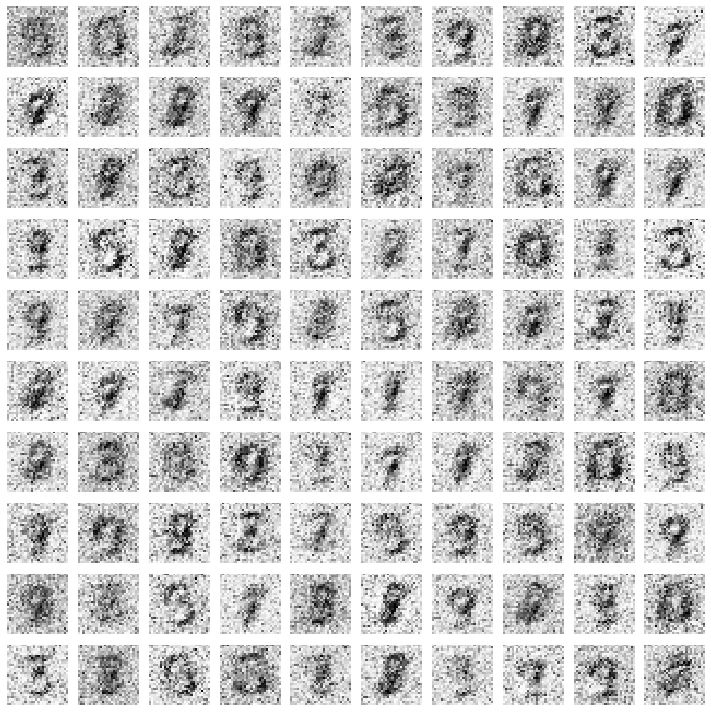

In [42]:
train(1, 128)